# Inisialisasi Library

In [1]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score,precision_score, f1_score, recall_score
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Inisialisasi Dataset

## Inisialisasi Football Data

In [2]:
filepath = '/content/drive/MyDrive/Tugas Akhir/Model'

#Membuka File CSV data statistik liga inggris
EPL1718 = pd.read_csv(filepath + '/Raw/EPL1718.csv')
EPL1819 = pd.read_csv(filepath + '/Raw/EPL1819.csv')
EPL1920 = pd.read_csv(filepath + '/Raw/EPL1920.csv')
EPL2021 = pd.read_csv(filepath + '/Raw/EPL2021.csv')
EPL2122 = pd.read_csv(filepath + '/Raw/EPL2122.csv')
EPL2223 = pd.read_csv(filepath + '/Raw/EPL2223.csv')
EPL2324 = pd.read_csv(filepath + '/Raw/EPL2324.csv')

#Menggabungkan Data Setiap Musim Menjadi Satu
footballdata = pd.concat([EPL1718,EPL1819, EPL1920,EPL2021,EPL2122,EPL2223,EPL2324], ignore_index=True)

## Web Scraping FBREF

In [3]:
try:
  #Data Scraping pertandingan English Premier League yang tersedia xG dari FBREF
  EPL1718xG = pd.read_html('https://fbref.com/en/comps/9/2017-2018/schedule/2017-2018-Premier-League-Scores-and-Fixtures', attrs={"id":"sched_2017-2018_9_1"})[0]
  EPL1819xG = pd.read_html('https://fbref.com/en/comps/9/2018-2019/schedule/2018-2019-Premier-League-Scores-and-Fixtures', attrs={"id":"sched_2018-2019_9_1"})[0]
  EPL1920xG = pd.read_html('https://fbref.com/en/comps/9/2019-2020/schedule/2019-2020-Premier-League-Scores-and-Fixtures', attrs={"id":"sched_2019-2020_9_1"})[0]
  EPL2021xG = pd.read_html('https://fbref.com/en/comps/9/2020-2021/schedule/2020-2021-Premier-League-Scores-and-Fixtures', attrs={"id":"sched_2020-2021_9_1"})[0]
  EPL2122xG = pd.read_html('https://fbref.com/en/comps/9/2021-2022/schedule/2021-2022-Premier-League-Scores-and-Fixtures', attrs={"id":"sched_2021-2022_9_1"})[0]
  EPL2223xG = pd.read_html('https://fbref.com/en/comps/9/2022-2023/schedule/2022-2023-Premier-League-Scores-and-Fixtures', attrs={"id":"sched_2022-2023_9_1"})[0]
  EPL2324xG = pd.read_html('https://fbref.com/en/comps/9/2023-2024/schedule/2023-2024-Premier-League-Scores-and-Fixtures', attrs={"id":"sched_2023-2024_9_1"})[0]
  print("Data Scraping FBREF berhasil diambil")

except Exception as e:
  EPL1718xG = pd.read_csv(filepath + "/Raw/EPL1718xG.csv")
  EPL1819xG = pd.read_csv(filepath + "/Raw/EPL1819xG.csv")
  EPL1920xG = pd.read_csv(filepath + "/Raw/EPL1920xG.csv")
  EPL2021xG = pd.read_csv(filepath + "/Raw/EPL2021xG.csv")
  EPL2122xG = pd.read_csv(filepath + "/Raw/EPL2122xG.csv")
  EPL2223xG = pd.read_csv(filepath + "/Raw/EPL2223xG.csv")
  EPL2324xG = pd.read_csv(filepath + "/Raw/EPL2324xG.csv")
  print("Data Scraping FBREF gagal diambil sehingga menggunakan data yang sudah diunduh")
  print(e)

#Menggabungkan Data Setiap Musim Menjadi Satu
fbref = pd.concat([EPL1718xG,EPL1819xG, EPL1920xG,EPL2021xG,EPL2122xG,EPL2223xG,EPL2324xG], ignore_index=True)
fbref.to_csv(filepath + '/Raw/fbref.csv', index=False)

Data Scraping FBREF berhasil diambil


# Pra-pemrosesan Data

## Menggabungkan footballdata dan fbref

In [4]:
#Menggabungkan dataset football-data dan football reference menjadi satu
def gabung (football_data, fbref):

    #Memilih fitur statistik pertandingan sepak bola dan menghapus fitur nilai taruhan
    football_data = football_data[['FTR','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]

    #Mengganti nama menyesuaikan kolom di football-data
    fbref = fbref.rename(columns={ "xG": "HxG", "xG.1": "AxG"})

    #mengurutkan data FBREF menurut tanggal dan nama home team
    fbref = fbref.sort_values(by=['Date','Home'],ascending=[True, True]).reset_index(drop=True)

    #Memilih Fitur xG untuk digabungkan
    fbref = fbref[['HxG','AxG']]

    #menghapus missing value
    fbref = fbref.dropna()

    #menggabungkan data statistik pertandingan sepak bola dengan data xG FBREF
    dataset= pd.merge(football_data, fbref, left_index=True, right_index=True)

    #mengatur urutan fitur di dataset
    dataset = dataset[['FTR','FTHG','FTAG','HTHG','HTAG','HxG','AxG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',]]

    return dataset

In [5]:
#memanggil fungsi penggabungan data
dataset = gabung(footballdata, fbref)
dataset

,FTR,FTHG,FTAG,HTHG,HTAG,HxG,AxG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,H,4,3,2,2,2.5,1.5,27,6,10,3,9,12,9,4,0,1,0,0
1,A,0,2,0,0,0.3,1.9,6,14,2,4,6,9,3,10,0,2,0,0
2,A,2,3,0,3,1.5,0.6,19,10,6,5,16,11,8,5,3,3,2,0
3,A,0,3,0,2,1.1,1.5,14,8,4,6,7,19,12,9,1,3,0,0
4,H,1,0,1,0,0.6,0.4,9,9,4,1,13,10,6,7,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,H,5,0,2,0,2.5,0.9,15,8,9,2,10,8,2,4,1,4,0,0
2656,H,2,0,2,0,4.5,0.5,36,4,14,3,14,11,10,2,1,1,0,1
2657,A,2,4,1,2,2.0,1.1,15,15,6,7,15,20,4,4,5,4,0,0
2658,H,3,1,2,1,1.9,0.4,28,3,12,2,3,12,11,2,0,1,0,0


## Menyimpan dataset xG


In [6]:
#Menyimpan dataset
dataset.to_csv(filepath + '/Dataset/DatasetxG.csv', index=False)

## Mengubah Tipe Data dan menjadikan kode

In [7]:
# Ubah Tipe Data
dataset['FTR'] = dataset['FTR'].astype(str)

# Mengubah nama tim dan hasil pertandingan sebagai kode
label_encoder = preprocessing.LabelEncoder()
dataset['FTR']= label_encoder.fit_transform(dataset['FTR'])

## Visualisasi Data

FTR
2    44.812030
0    32.556391
1    22.631579
Name: proportion, dtype: float64


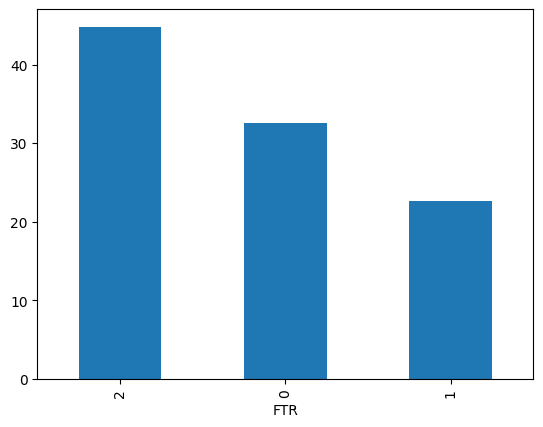

In [8]:
# Frequency distribution on the FTR attribute
a = dataset['FTR'].value_counts(normalize=True) * 100
a.plot(kind='bar')
print(a)
plt.show()

## Data Splitting

In [9]:
#Data Split Dataset xG
train_df, test_df = train_test_split(dataset, test_size=0.2, shuffle=False)

y_train1 = train_df['FTR']
X_train1 = train_df[train_df.columns[3:].tolist()]

y_test1 = test_df['FTR']
X_test1 = test_df[test_df.columns[3:].tolist()]

y_train2 = train_df['FTR']
X_train2 = train_df[train_df.columns[3:5].tolist()+train_df.columns[7:].tolist()]

y_test2 = test_df['FTR']
X_test2 = test_df[test_df.columns[3:5].tolist()+test_df.columns[7:].tolist()]

print("Train    xG:", X_train1.shape, y_train1.shape)
print("Test     xG:", X_test1.shape, y_test1.shape)

print("Train nonxG:", X_train2.shape, y_train2.shape)
print("Test  nonxG:", X_test2.shape, y_test2.shape)

Train    xG: (2128, 16) (2128,)
Test     xG: (532, 16) (532,)
Train nonxG: (2128, 14) (2128,)
Test  nonxG: (532, 14) (532,)


# Metode Penelitian


## Hyperparameter Tuning

In [41]:
#Mencari K Optimal sebelum hyperparameter tuning

#menggunakan classifier default
classifiers_def = {
    "RandomForest" : (RandomForestClassifier(random_state=0)),
    "XGBoost" : (XGBClassifier(random_state=0))
}

k_values = range(2, 11)
mean_scores = []

for name, model in classifiers_def.items():
  for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train1, y_train1, cv=kf)
    mean_score = scores.mean()
    mean_scores.append(mean_score)
    print(f"k = {k}: mean accuracy = {mean_score:.4f}")

k = 2: mean accuracy = 0.6429
k = 3: mean accuracy = 0.6429
k = 4: mean accuracy = 0.6443
k = 5: mean accuracy = 0.6443
k = 6: mean accuracy = 0.6504
k = 7: mean accuracy = 0.6438
k = 8: mean accuracy = 0.6499
k = 9: mean accuracy = 0.6382
k = 10: mean accuracy = 0.6400
k = 2: mean accuracy = 0.6208
k = 3: mean accuracy = 0.6062
k = 4: mean accuracy = 0.6198
k = 5: mean accuracy = 0.6175
k = 6: mean accuracy = 0.6100
k = 7: mean accuracy = 0.6184
k = 8: mean accuracy = 0.6156
k = 9: mean accuracy = 0.6194
k = 10: mean accuracy = 0.6198


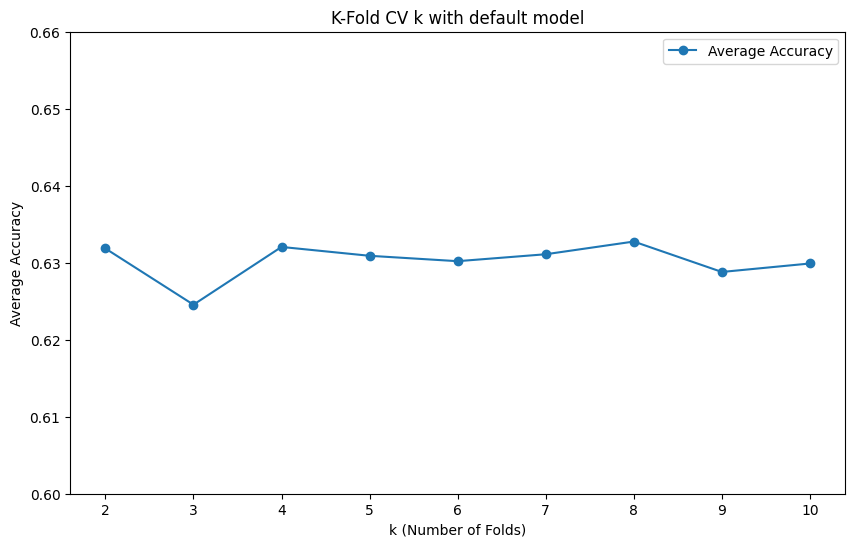

In [56]:
import matplotlib.pyplot as plt

# Data
k_values = list(range(2, 11))

# Accuracy values for each model
random_forest_accuracy = [0.6429, 0.6429, 0.6443, 0.6443, 0.6504, 0.6438, 0.6499, 0.6382, 0.6400]
xgboost_accuracy = [0.6208, 0.6062, 0.6198, 0.6175, 0.6100, 0.6184, 0.6156, 0.6194, 0.6198]

# Calculate average accuracy across both models for each k
average_accuracy = [(rf + xgb) / 2 for rf, xgb in zip(random_forest_accuracy, xgboost_accuracy)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, average_accuracy, marker='o', label='Average Accuracy')
plt.xlabel('k (Number of Folds)')
plt.ylabel('Average Accuracy')
plt.title('K-Fold CV k with default model')
plt.legend()
plt.xticks(k_values)
plt.ylim(0.6, 0.66)

plt.show()


In [40]:
param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.7,0.8, 0.9, 1.0],
    'colsample_bytree': [0.7,0.8, 0.9, 1.0]
}

classifiers_1 = {
    "RandomForest" : (RandomForestClassifier(random_state=0), param_grid_rf),
    "XGBoost" : (XGBClassifier(random_state=0), param_grid_xgb)
}

grid_result = {}
for name, (model, param_grid) in classifiers_1.items():
  random_search1 = RandomizedSearchCV(
      estimator=model,
      param_distributions=param_grid,
      n_iter=10,
      cv=KFold(n_splits = 8),
      scoring='accuracy',
      random_state=0)
  random_search1.fit(X_train1, y_train1)
  grid_result[name] = random_search1.best_params_
  print(f"hyperparameter for {name}: {random_search1.best_params_}")
  print(f"score for {name}: {random_search1.best_score_:.4f}\n")

hyperparameter for RandomForest: {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_depth': 30}
score for RandomForest: 0.6602

hyperparameter for XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
score for XGBoost: 0.6532



## Pengujian model

### Random Forest xG

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       164
           1       0.38      0.13      0.20       113
           2       0.71      0.85      0.78       255

    accuracy                           0.67       532
   macro avg       0.58      0.58      0.56       532
weighted avg       0.62      0.67      0.63       532

0.6654135338345865


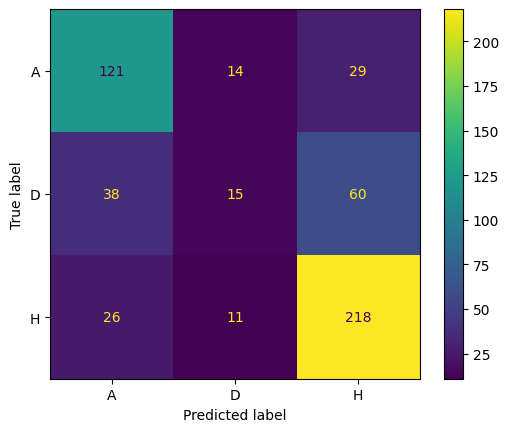

In [10]:
#Random Forest dengan xG
clf_rf_xg = RandomForestClassifier(
         n_estimators = 100,
         min_samples_split = 20,
         min_samples_leaf = 4,
         max_depth = 30,
         random_state = 0)

#Pelatihan dan Pengujian
M1 = clf_rf_xg.fit(X_train1, y_train1)
M1_pred = M1.predict(X_test1)

#Melihat Akurasi dan Heatmap Random Forest dengan xG
print(classification_report(y_test1,M1_pred))
print(accuracy_score(y_test1,M1_pred))

labels = ['A', 'D', 'H']
cf_matrix = confusion_matrix(y_test1,M1_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=labels)
cmd.plot()

### XGBoost xG

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       164
           1       0.34      0.11      0.16       113
           2       0.69      0.84      0.76       255

    accuracy                           0.66       532
   macro avg       0.56      0.57      0.54       532
weighted avg       0.61      0.66      0.62       532

0.6578947368421053


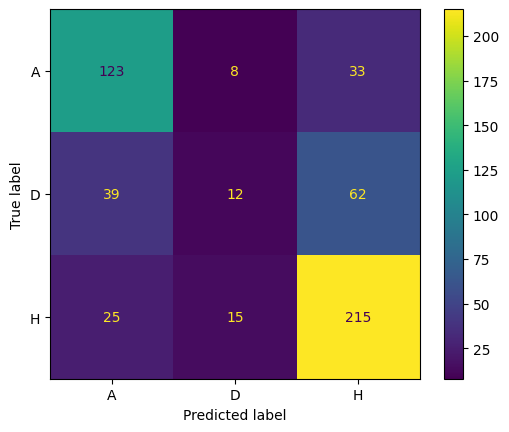

In [11]:
#XGBoost dengan xG
clf_xgb_xg = XGBClassifier(
      n_estimators = 100,
      max_depth = 3,
      learning_rate = 0.05,
      subsample = 1.0,
      colsample_bytree = 1.0,
      random_state = 0)

#Pelatihan dan Pengujian
M2 = clf_xgb_xg.fit(X_train1, y_train1)
M2_pred = M2.predict(X_test1)

#Melihat Akurasi dan Heatmap XGBoost dengan xG
print(classification_report(y_test1,M2_pred))
print(accuracy_score(y_test1,M2_pred))

labels = ['A', 'D', 'H']
cf_matrix = confusion_matrix(y_test1,M2_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=labels)
cmd.plot()

### Random Forest Tanpa xG

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       164
           1       0.26      0.09      0.13       113
           2       0.70      0.85      0.77       255

    accuracy                           0.65       532
   macro avg       0.54      0.55      0.53       532
weighted avg       0.59      0.65      0.61       532

0.6484962406015038


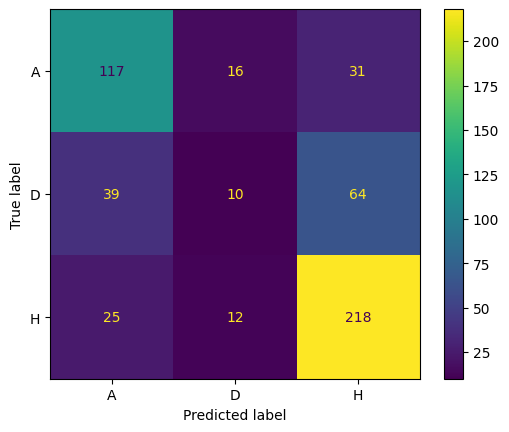

In [12]:
#Random Forest tanpa xG
clf_rf = RandomForestClassifier(
         n_estimators = 100,
         min_samples_split = 20,
         min_samples_leaf = 4,
         max_depth = 30,
         random_state = 0)

#Pelatihan dan Pengujian
M3 = clf_rf.fit(X_train2, y_train2)
M3_pred = M3.predict(X_test2)

#Melihat Akurasi dan Heatmap Random Forest tanpa xG
print(classification_report(y_test2,M3_pred))
print(accuracy_score(y_test2,M3_pred))

labels = ['A', 'D', 'H']
cf_matrix = confusion_matrix(y_test2,M3_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=labels)
cmd.plot()

### XGBoost tanpa xG

              precision    recall  f1-score   support

           0       0.66      0.74      0.70       164
           1       0.27      0.09      0.13       113
           2       0.69      0.85      0.76       255

    accuracy                           0.65       532
   macro avg       0.54      0.56      0.53       532
weighted avg       0.59      0.65      0.61       532

0.6522556390977443


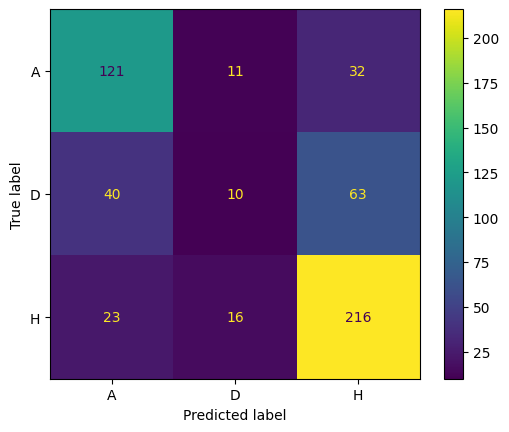

In [13]:
#XGBoost tanpa xG
clf_xgb = XGBClassifier(
      n_estimators = 100,
      max_depth = 3,
      learning_rate = 0.05,
      subsample = 1.0,
      colsample_bytree = 1.0,
      random_state = 0)

#Pelatihan dan Pengujian
M4 = clf_xgb.fit(X_train2, y_train2)
M4_pred = M4.predict(X_test2)

#Melihat Akurasi dan Heatmap XGBoost tanpa xG
print(classification_report(y_test2,M4_pred))
print(accuracy_score(y_test2,M4_pred))

labels = ['A', 'D', 'H']
cf_matrix = confusion_matrix(y_test2,M4_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=labels)
cmd.plot()

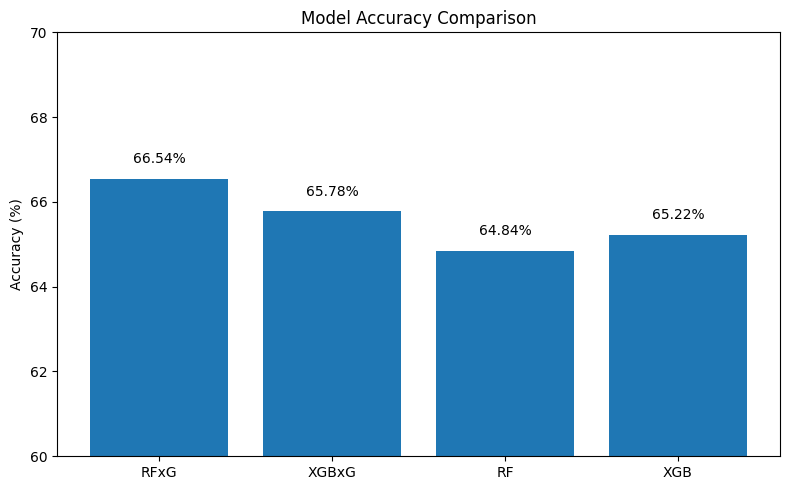

In [65]:
import matplotlib.pyplot as plt

# Model names and accuracies
models = ['RFxG', 'XGBxG', 'RF', 'XGB']
accuracies = [66.54, 65.78, 64.84, 65.22]

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies)

# Annotate the accuracy on top of each bar
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.3, f'{acc:.2f}%', ha='center', va='bottom', fontsize=10)

# Title and labels
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(60, 70)

plt.grid(False)
plt.tight_layout()
plt.show()


## Menilai Fitur xG

In [14]:
#Mengevaluasi nilai fitur xG
feature_scores_rf_xg = pd.Series(M1.feature_importances_, index=X_train1.columns).sort_values(ascending=False).round(4)
feature_scores_xgb_xg = pd.Series(M2.feature_importances_, index=X_train1.columns).sort_values(ascending=False).round(4)
feature_scores_rf = pd.Series(M3.feature_importances_, index=X_train2.columns).sort_values(ascending=False).round(4)
feature_scores_xgb = pd.Series(M4.feature_importances_, index=X_train2.columns).sort_values(ascending=False).round(4)

In [15]:
feature_scores = pd.DataFrame([feature_scores_rf_xg,
                               feature_scores_xgb_xg,
                               feature_scores_rf,
                               feature_scores_xgb])
feature_scores

,HTAG,HTHG,HST,AST,HxG,AxG,AS,HS,HC,HF,AF,AC,AY,HY,AR,HR
0,0.1769,0.1696,0.1426,0.1098,0.0630,0.0564,0.0526,0.0504,0.0352,0.0336,0.0325,0.0287,0.0232,0.0204,0.0035,0.0017
1,0.1915,0.2005,0.1213,0.1242,0.0403,0.0384,0.0299,0.0246,0.0376,0.0247,0.0168,0.0223,0.0226,0.0269,0.0470,0.0314
2,0.1865,0.1689,0.1522,0.1328,NaN,NaN,0.0659,0.0681,0.0452,0.0419,0.0380,0.0364,0.0286,0.0280,0.0040,0.0038
3,0.2043,0.2208,0.1235,0.1303,NaN,NaN,0.0307,0.0298,0.0380,0.0275,0.0181,0.0275,0.0282,0.0306,0.0588,0.0322


In [16]:
avg_fs = feature_scores.mean(axis=0)

print(avg_fs)

HTAG    0.189800
HTHG    0.189950
HST     0.134900
AST     0.124275
HxG     0.051650
AxG     0.047400
AS      0.044775
HS      0.043225
HC      0.039000
HF      0.031925
AF      0.026350
AC      0.028725
AY      0.025650
HY      0.026475
AR      0.028325
HR      0.017275
dtype: float64


<ipython-input-17-056a75232c92>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(avg_fs.index)


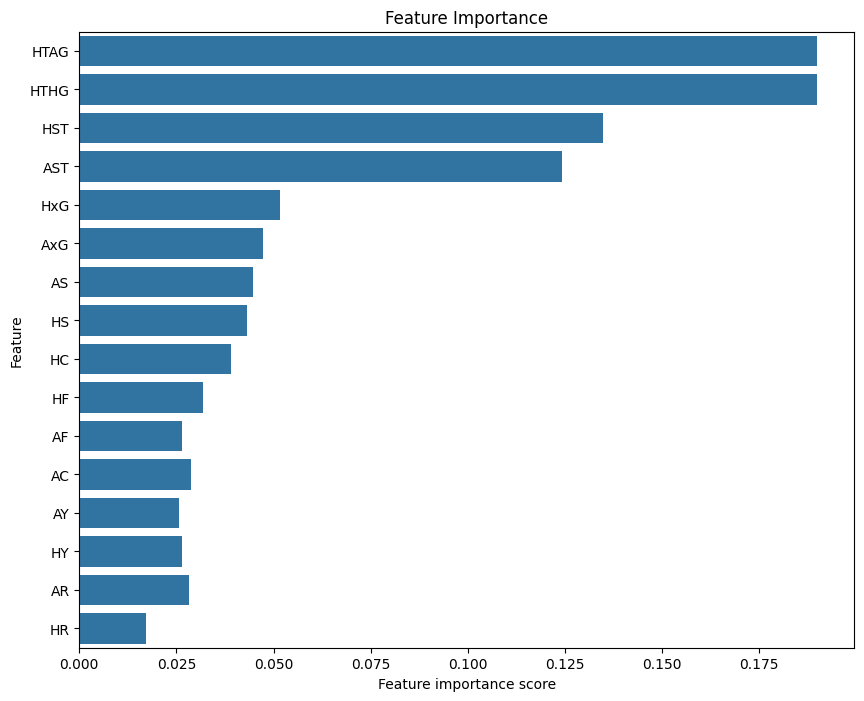

In [17]:
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.barplot(x=avg_fs, y=avg_fs.index)
ax.set_title("Feature Importance")
ax.set_yticklabels(avg_fs.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Feature")
plt.show()

## Simpan Model

In [18]:
#menyimpan model
import joblib
import shutil

joblib.dump(M1, 'random_forest_xg.pkl')
joblib.dump(M2, 'xgboost_xg.pkl')
joblib.dump(M3, 'random_forest.pkl')
joblib.dump(M4, 'xgboost.pkl')

shutil.move("random_forest_xg.pkl", filepath + "/ML/random_forest_xg.pkl")
shutil.move("xgboost_xg.pkl", filepath + "/ML/xgboost_xg.pkl")
shutil.move("random_forest.pkl", filepath + "/ML/random_forest.pkl")
shutil.move("xgboost.pkl", filepath + "/ML/xgboost.pkl")

'/content/drive/MyDrive/Tugas Akhir/Model/ML/xgboost.pkl'